In [1]:
import cv2
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.io import imshow
from scipy.spatial import distance
import pandas as pd

2021-11-22 15:26:01.783128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vitoria/anaconda3/envs/sinfo/lib/python3.7/site-packages/cv2/../../lib64:
2021-11-22 15:26:01.783223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
facenet_model = keras.models.load_model("facenet_keras.h5")

2021-11-22 15:26:28.909705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vitoria/anaconda3/envs/sinfo/lib/python3.7/site-packages/cv2/../../lib64:
2021-11-22 15:26:28.909730: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-22 15:26:28.909755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vitoria-X510UAR): /proc/driver/nvidia/version does not exist
2021-11-22 15:26:28.909947: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def read_image(path):
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resize = cv2.resize(image_rgb, (160, 160))
    return image_resize

In [4]:
def get_embeddings(face, facenet_model):

    face = cv2.resize(face, (160, 160))/255    
    face = face[None, ...]    
    
    return facenet_model.predict(face)[0]

In [5]:
def reduction(pca, x):
    pca.fit(x)
    return pca.fit_transform(x)

In [6]:
eu = read_image('imgs_teste/eu.jpeg')
outroeu = read_image('imgs_teste/outroeu.jpg')
ufpi = read_image('imgs_teste/ufpi.jpg')

In [7]:
emb_eu = get_embeddings(eu, facenet_model)
emb_outroeu = get_embeddings(outroeu, facenet_model)
emb_ufpi = get_embeddings(ufpi, facenet_model)

emb_eu.shape, emb_outroeu.shape, emb_ufpi.shape

((128,), (128,), (128,))

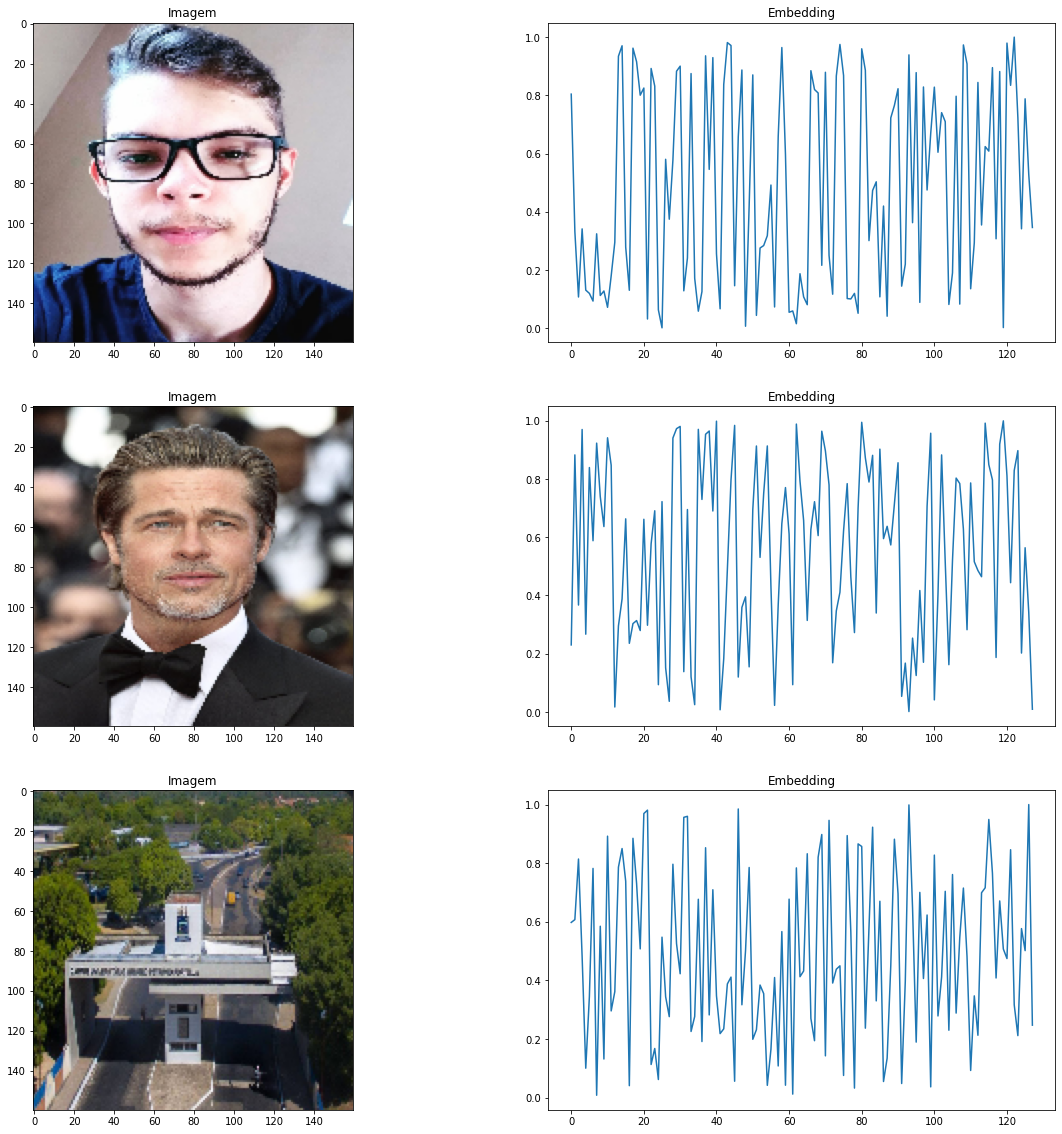

In [8]:
fig = plt.figure(figsize=(20,20))
imgs = [eu, outroeu, ufpi]
embs = [emb_eu, emb_outroeu, emb_ufpi]
normalized = []

cont = 1
for id in range(len(imgs)):
    img = imgs[id]
    emb = embs[id]

    # Normalizando os valores
    min_, max_ = np.min(emb), np.max(emb)

    for i in range(len(emb)):
        if emb[i] < 0:
            emb[i] += max_
        emb[i] /= max_

    normalized.append(emb)

    ax = fig.add_subplot(3,2,cont)
    ax.imshow(img)
    ax.set_title('Imagem')
    cont += 1

    ax = fig.add_subplot(3,2,cont)
    ax.plot(emb)
    ax.set_title('Embedding')
    cont += 1


plt.show()

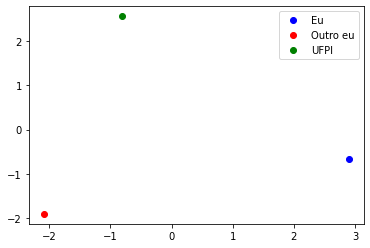

In [9]:
pca = PCA(n_components=2)

x = np.array([emb_eu, emb_outroeu, emb_ufpi])
new_x = reduction(pca, x)

plt.plot(new_x[0][0], new_x[0][1], 'bo')
plt.plot(new_x[1][0], new_x[1][1], 'ro')
plt.plot(new_x[2][0], new_x[2][1], 'go')
plt.legend(['Eu', 'Outro eu', 'UFPI'])

In [10]:
import seaborn as sns

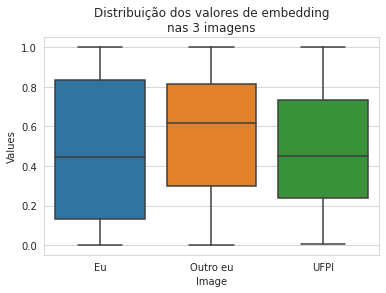

In [11]:
df = pd.DataFrame({
    'Image': ['Eu']*128 + ['Outro eu']*128 + ['UFPI']*128,
    'Values': np.concatenate([normalized[0], normalized[1], normalized[2]])
})

sns.set_style('whitegrid')
ax = sns.boxplot(x='Image',y='Values', data=df).set(title=f'Distribuição dos valores de embedding\nnas 3 imagens')